In [80]:
#Importing the libraries
import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import math
import gc

In [81]:
def generate_input_range(start, stop, step):
    
    return np.linspace(start, stop, int((stop - start) / step)).reshape(-1, 1)

def sinc_function(x):
    
    scaled_x = 5 * np.pi * x
    # Handle the case where x == 0 (since sin(0) / 0 is 1 by definition)
    with np.errstate(divide='ignore', invalid='ignore'):
        result = np.where(scaled_x == 0, 1.0, np.sin(scaled_x) / scaled_x)
    return result

# Generate the input values from -1.2 to 1.2
ip = generate_input_range(-1.2, 1.2, 0.005)

# Compute the sinc function for the generated input
op = sinc_function(ip)

# Display the results
print("Input (ip):\n", ip[:5])  # First 5 values
print("Output (op):\n", op[:5])  # First 5 results


Input (ip):
 [[-1.2       ]
 [-1.19498956]
 [-1.18997912]
 [-1.18496868]
 [-1.17995825]]
Output (op):
 [[-3.89817183e-17]
 [-4.18854482e-03]
 [-8.38632075e-03]
 [-1.25674559e-02]
 [-1.67059629e-02]]


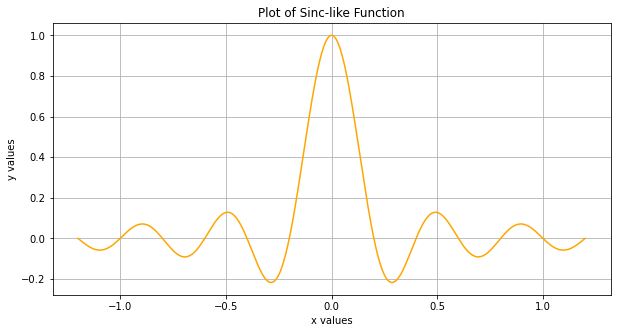

In [82]:
# Convert the NumPy arrays 'ip' and 'op' to PyTorch tensors
x = torch.tensor(ip, dtype=torch.float32)
y = torch.tensor(op, dtype=torch.float32)

# Plotting the function using Matplotlib
plt.figure(figsize=(10, 5))
plt.xlabel('x values')
plt.ylabel('y values')
plt.plot(x.numpy(), y.numpy(), color="orange")  # Convert tensors to NumPy arrays for plotting
plt.title('Plot of Sinc-like Function')
plt.grid(True)
plt.show()


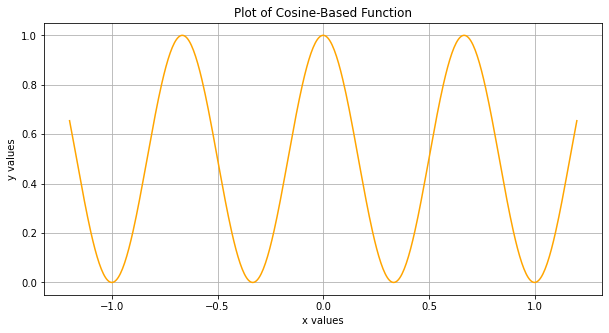

In [83]:
x2 = generate_input_range(-1.2, 1.2, 0.005)

# Define the second function: a cosine-based function
def cosine_function(x):
   
    return (np.cos(3 * np.pi * x) / 2) + 0.5

# Compute the output using the cosine function
op2 = cosine_function(x2)

# Convert the input and output to PyTorch tensors
x2_tensor = torch.tensor(x2, dtype=torch.float32)
y2_tensor = torch.tensor(op2, dtype=torch.float32)

# Plotting the second function using Matplotlib
plt.figure(figsize=(10, 5))
plt.xlabel('x values')
plt.ylabel('y values')
plt.plot(x2_tensor.numpy(), y2_tensor.numpy(), color='orange')  # Convert tensors to NumPy for plotting
plt.title('Plot of Cosine-Based Function')
plt.grid(True)
plt.show()

In [84]:
loss_func = torch.nn.MSELoss()

In [85]:
def count_model_parameters(model):
    
    total_params = 0
    for param in model.parameters():
        total_params += param.numel()  # numel() returns the number of elements in the parameter tensor
    return total_params

In [86]:
class Model_1(nn.Module):
    def __init__(self):
        super(Model_1, self).__init__()
        # Define layers
        self.layer1 = nn.Linear(1, 4)
        self.layer2 = nn.Linear(4, 8)
        self.layer3 = nn.Linear(8, 12)
        self.layer4 = nn.Linear(12, 10)
        self.layer5 = nn.Linear(10, 10)
        self.layer6 = nn.Linear(10, 10)
        self.layer7 = nn.Linear(10, 6)
        self.output_layer = nn.Linear(6, 1)
    
    def forward(self, x):
        # Apply layers with Leaky ReLU activation
        x = nn.functional.leaky_relu(self.layer1(x))
        x = nn.functional.leaky_relu(self.layer2(x))
        x = nn.functional.leaky_relu(self.layer3(x))
        x = nn.functional.leaky_relu(self.layer4(x))
        x = nn.functional.leaky_relu(self.layer5(x))
        x = nn.functional.leaky_relu(self.layer6(x))
        x = nn.functional.leaky_relu(self.layer7(x))
        
        # Output layer without activation
        x = self.output_layer(x)
        return x

def count_model_parameters(model):
    
    return sum(p.numel() for p in model.parameters())

# Instantiate the model and print the number of parameters
model_1 = Model_1()
print(f'Number of params in Model_1: {count_model_parameters(model_1)}')


Number of params in Model_1: 579


In [87]:
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        # Define the layers
        self.l1 = nn.Linear(1, 81)
        self.l2 = nn.Linear(81, 5)
        self.l3 = nn.Linear(5, 1)
        
    def forward(self, x):
        # Pass through the layers with Leaky ReLU activations
        x = torch.nn.functional.leaky_relu(self.l1(x))
        x = torch.nn.functional.leaky_relu(self.l2(x))
        x = self.l3(x)
        return x

# Calculate the total number of parameters using the renamed function
model2 = Model2()
print('Number of parameters in Model 2 -', count_model_parameters(model2))


Number of parameters in Model 2 - 578


In [88]:
# Define Model_3
class Model_3(nn.Module):
    def __init__(self):
        super(Model_3, self).__init__()
        self.l1 = nn.Linear(1, 192)
        self.l2 = nn.Linear(192, 1)
    
    def forward(self, x):
        x = nn.functional.leaky_relu(self.l1(x))  # Leaky ReLU after first layer
        x = self.l2(x)  # Output layer without activation
        return x

# Count the number of parameters in the models
def count_model_parameters(model):
    
    total_params = 0
    for param in model.parameters():
        total_params += param.numel()
    return total_params

# Print the number of parameters for both models
print('Number of parameters in Model 3 - ', count_model_parameters(Model_3()))


Number of parameters in Model 3 -  577


In [89]:
def train_model(model, inputs, targets, loss_function, optimizer, max_epochs=30000, convergence_threshold=0.001, patience=3, convergence_delta=1e-5):
    
    stop_training = False
    epoch_history = []
    loss_history = []

    for epoch in range(max_epochs):
        if stop_training:
            return epoch_history, loss_history, final_predictions
        
        # Forward pass: Make predictions
        final_predictions = model(inputs)
        
        # Compute the loss
        loss = loss_function(final_predictions, targets)
        
        # Zero the gradients, backpropagate, and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record the current epoch and loss
        epoch_history.append(epoch)
        loss_history.append(loss.detach().numpy())

        # Print progress every 300 epochs
        if epoch % 300 == 0: 
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

        # Check for convergence
        if loss_history[-1] < convergence_threshold and epoch > patience:
            # Ensure the change in loss is minimal over the last few epochs
            if (abs(loss_history[-3] - loss_history[-2]) < convergence_delta and
                abs(loss_history[-2] - loss_history[-1]) < convergence_delta):
                print(f"Convergence reached at Epoch {epoch}, Loss: {loss_history[-1]:.4f}")
                stop_training = True

    return epoch_history, loss_history, final_predictions


In [90]:
# Initialize Model_1
model_1 = Model_1()

# Define optimizer (RMSprop) for Model_1 with a learning rate of 0.001
optimizer = torch.optim.RMSprop(model_1.parameters(), lr=0.001)

# Train the model using the x and y tensors
# m1x_epoch_arr: stores the epoch values
# m1x_loss_arr: stores the loss values during training
# m1y_prediction: stores the final predictions of the model after training
m1x_epoch_arr, m1x_loss_arr, m1y_prediction = train(model_1, x2_tensor, y2_tensor)


Epoch - 0, Loss = 0.3770
Epoch - 300, Loss = 0.1198
Epoch - 600, Loss = 0.1185
Epoch - 900, Loss = 0.1015
Epoch - 1200, Loss = 0.0862
Epoch - 1500, Loss = 0.0688
Epoch - 1800, Loss = 0.0605
Epoch - 2100, Loss = 0.0583
Epoch - 2400, Loss = 0.0570
Epoch - 2700, Loss = 0.0584
Epoch - 3000, Loss = 0.0550
Epoch - 3300, Loss = 0.0577
Epoch - 3600, Loss = 0.0567
Epoch - 3900, Loss = 0.0546
Epoch - 4200, Loss = 0.0537
Epoch - 4500, Loss = 0.0520
Epoch - 4800, Loss = 0.0525
Epoch - 5100, Loss = 0.0392
Epoch - 5400, Loss = 0.0188
Epoch - 5700, Loss = 0.0152
Epoch - 6000, Loss = 0.0119
Epoch - 6300, Loss = 0.0132
Epoch - 6600, Loss = 0.0060
Epoch - 6900, Loss = 0.0060
Epoch - 7200, Loss = 0.0052
Epoch - 7500, Loss = 0.0053
Epoch - 7800, Loss = 0.0047
Epoch - 8100, Loss = 0.0046
Epoch - 8400, Loss = 0.0027
Epoch - 8700, Loss = 0.0011
Epoch - 9000, Loss = 0.0018
Epoch - 9300, Loss = 0.0056
Epoch - 9600, Loss = 0.0028
Epoch - 9900, Loss = 0.0040
Epoch - 10200, Loss = 0.0034
Epoch - 10500, Loss = 0.0

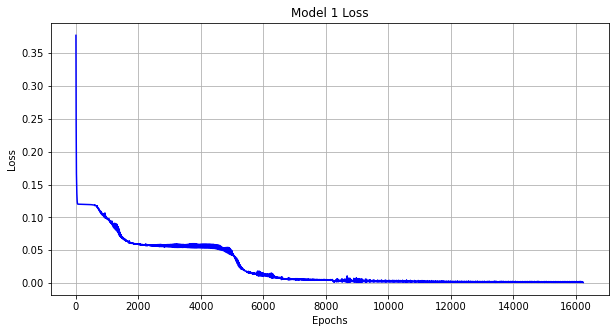

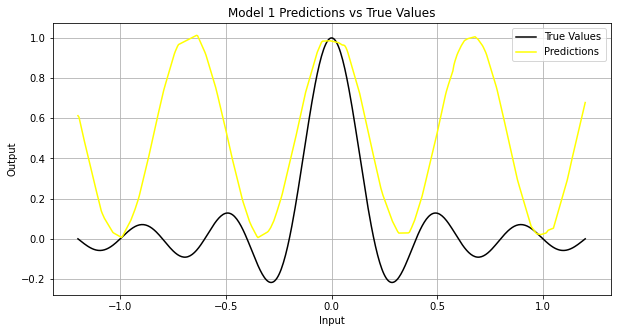

In [93]:
plt.figure(figsize=(10, 5))
plt.plot(m1x_epoch_arr, m1x_loss_arr, color="blue")
plt.title('Model 1 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Step 7: Plot the true vs predicted data for Model 1
plt.figure(figsize=(10, 5))
plt.plot(x.numpy(), y.numpy(), color="black", label='True Values')
plt.plot(x.numpy(), m1y_prediction.data.numpy(), color="yellow", label='Predictions')
plt.title('Model 1 Predictions vs True Values')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()

In [95]:
# Initialize the model
model_2 = Model_2()

# Define the optimizer using RMSprop with the learning rate of 0.001
optimizer = torch.optim.RMSprop(model_2.parameters(), lr=0.001)

# Train the model using the previously defined 'train' function
epoch_values, loss_values, predicted_output = train(model_2, x2_tensor, y2_tensor)

# Print the result
print(f"Training completed. Final prediction:\n{predicted_output}")


Epoch - 0, Loss = 0.1890
Epoch - 300, Loss = 0.0830
Epoch - 600, Loss = 0.0574
Epoch - 900, Loss = 0.0321
Epoch - 1200, Loss = 0.0189
Epoch - 1500, Loss = 0.0118
Epoch - 1800, Loss = 0.0081
Epoch - 2100, Loss = 0.0060
Epoch - 2400, Loss = 0.0049
Epoch - 2700, Loss = 0.0042
Epoch - 3000, Loss = 0.0038
Epoch - 3300, Loss = 0.0032
Epoch - 3600, Loss = 0.0032
Epoch - 3900, Loss = 0.0031
Epoch - 4200, Loss = 0.0029
Epoch - 4500, Loss = 0.0028
Epoch - 4800, Loss = 0.0027
Epoch - 5100, Loss = 0.0027
Epoch - 5400, Loss = 0.0026
Epoch - 5700, Loss = 0.0026
Epoch - 6000, Loss = 0.0025
Epoch - 6300, Loss = 0.0024
Epoch - 6600, Loss = 0.0025
Epoch - 6900, Loss = 0.0024
Epoch - 7200, Loss = 0.0023
Epoch - 7500, Loss = 0.0022
Epoch - 7800, Loss = 0.0022
Epoch - 8100, Loss = 0.0021
Epoch - 8400, Loss = 0.0021
Epoch - 8700, Loss = 0.0020
Epoch - 9000, Loss = 0.0020
Epoch - 9300, Loss = 0.0020
Epoch - 9600, Loss = 0.0019
Epoch - 9900, Loss = 0.0019
Epoch - 10200, Loss = 0.0019
Epoch - 10500, Loss = 0.0

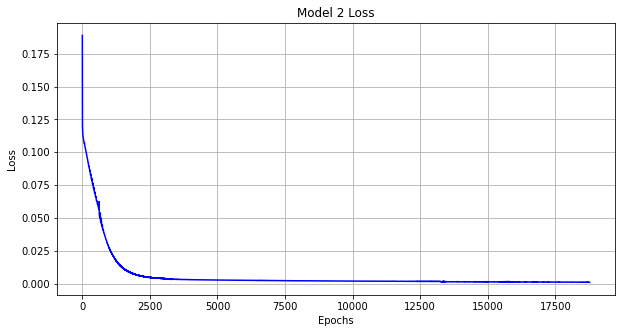

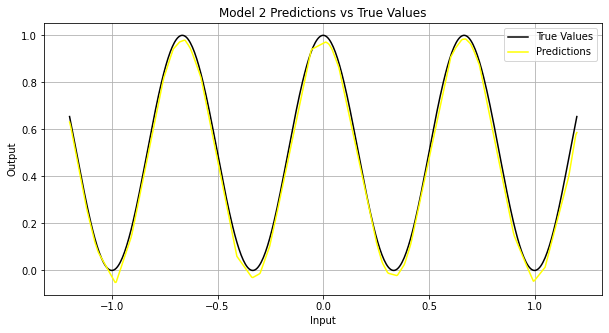

In [96]:
# Plot the loss curve for Model 2
plt.figure(figsize=(10, 5))
plt.plot(epoch_values, loss_values, color="blue")
plt.title('Model 2 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Plot the true vs predicted data for Model 2
plt.figure(figsize=(10, 5))
plt.plot(x2_tensor.numpy(), y2_tensor.numpy(), color="black", label='True Values')
plt.plot(x2_tensor.numpy(), predicted_output.data.numpy(), color="yellow", label='Predictions')
plt.title('Model 2 Predictions vs True Values')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()

In [69]:
# Instantiate the model
model_3 = Model_3()

# Define the optimizer, using RMSprop with a learning rate of 0.001
optimizer = torch.optim.RMSprop(model_3.parameters(), lr=0.001)

# Train the model by passing the model, input x, and target y to the training function
m3_epoch_values, m3_loss_values, m3_predictions = train(model_3, x, y)

# Optionally print or log the results
print(f"Training completed. Final loss: {m3_loss_values[-1]:.6f}")


Epoch - 0, Loss = 0.0990
Epoch - 300, Loss = 0.0336
Epoch - 600, Loss = 0.0248
Epoch - 900, Loss = 0.0187
Epoch - 1200, Loss = 0.0149
Epoch - 1500, Loss = 0.0125
Epoch - 1800, Loss = 0.0108
Epoch - 2100, Loss = 0.0096
Epoch - 2400, Loss = 0.0088
Epoch - 2700, Loss = 0.0081
Epoch - 3000, Loss = 0.0076
Epoch - 3300, Loss = 0.0072
Epoch - 3600, Loss = 0.0069
Epoch - 3900, Loss = 0.0066
Epoch - 4200, Loss = 0.0063
Epoch - 4500, Loss = 0.0061
Epoch - 4800, Loss = 0.0059
Epoch - 5100, Loss = 0.0058
Epoch - 5400, Loss = 0.0056
Epoch - 5700, Loss = 0.0055
Epoch - 6000, Loss = 0.0054
Epoch - 6300, Loss = 0.0052
Epoch - 6600, Loss = 0.0051
Epoch - 6900, Loss = 0.0050
Epoch - 7200, Loss = 0.0049
Epoch - 7500, Loss = 0.0048
Epoch - 7800, Loss = 0.0047
Epoch - 8100, Loss = 0.0047
Epoch - 8400, Loss = 0.0046
Epoch - 8700, Loss = 0.0045
Epoch - 9000, Loss = 0.0044
Epoch - 9300, Loss = 0.0044
Epoch - 9600, Loss = 0.0043
Epoch - 9900, Loss = 0.0043
Epoch - 10200, Loss = 0.0042
Epoch - 10500, Loss = 0.0

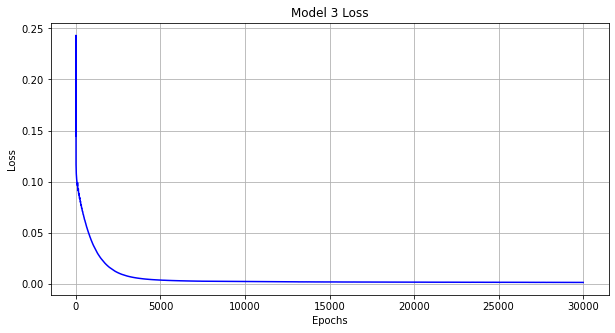

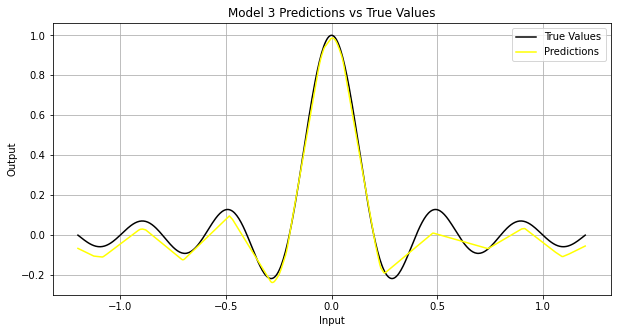

In [97]:
plt.figure(figsize=(10, 5))
plt.plot(m3_epoch_values, m3_loss_values, color="blue")
plt.title('Model 3 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Plot the true vs predicted data for Model 3
plt.figure(figsize=(10, 5))
plt.plot(x.numpy(), y.numpy(), color="black", label='True Values')
plt.plot(x.numpy(), m3_predictions.data.numpy(), color="yellow", label='Predictions')
plt.title('Model 3 Predictions vs True Values')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()

In [70]:
# Initialize the model (Model_1) for function 2 output
model_1 = Model_1()

# Define the optimizer using RMSprop with a learning rate of 0.001
optimizer = torch.optim.RMSprop(model_1.parameters(), lr=0.001)

# Train the model with x2 (input) and y2 (output of the cosine-based function)
m1x2_epoch_arr, m1x2_loss_arr, m1y2_prediction = train(model_1, x2_tensor, y2_tensor)

# Output the results (epoch values, loss values, and predictions)
print(f"Training completed. Total epochs: {len(m1x2_epoch_arr)}")


Epoch - 0, Loss = 0.1696
Epoch - 300, Loss = 0.0793
Epoch - 600, Loss = 0.0355
Epoch - 900, Loss = 0.0023
Epoch - 1200, Loss = 0.0014
Epoch - 1500, Loss = 0.0017
Epoch - 1800, Loss = 0.0018
Epoch - 2100, Loss = 0.0013
Epoch - 2400, Loss = 0.0012
Epoch - 2700, Loss = 0.0014
Epoch - 3000, Loss = 0.0013
Epoch - 3300, Loss = 0.0014
Epoch - 3600, Loss = 0.0013
Epoch - 3900, Loss = 0.0010
Epoch - 4200, Loss = 0.0012
Epoch - 4500, Loss = 0.0012
Epoch - 4800, Loss = 0.0010
Epoch - 5100, Loss = 0.0014
Epoch - 5400, Loss = 0.0008
Epoch - 5700, Loss = 0.0010
Epoch - 6000, Loss = 0.0013
Epoch - 6300, Loss = 0.0008
Epoch - 6600, Loss = 0.0015
Epoch - 6900, Loss = 0.0009
Epoch - 7200, Loss = 0.0010
Epoch - 7500, Loss = 0.0008
Epoch - 7800, Loss = 0.0010
Epoch - 8100, Loss = 0.0010
Epoch - 8400, Loss = 0.0008
Epoch - 8700, Loss = 0.0008
Epoch - 9000, Loss = 0.0012
Epoch - 9300, Loss = 0.0008
Epoch - 9600, Loss = 0.0005
Epoch - 9900, Loss = 0.0015
Epoch - 10200, Loss = 0.0006
Epoch - 10500, Loss = 0.0

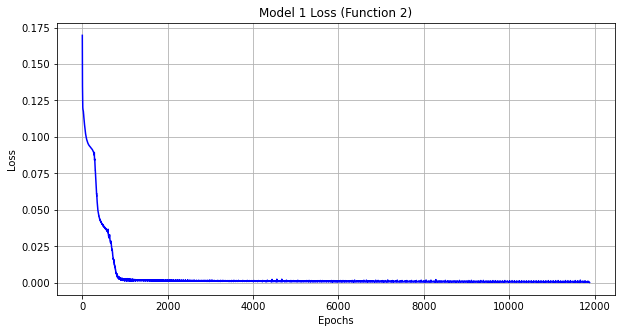

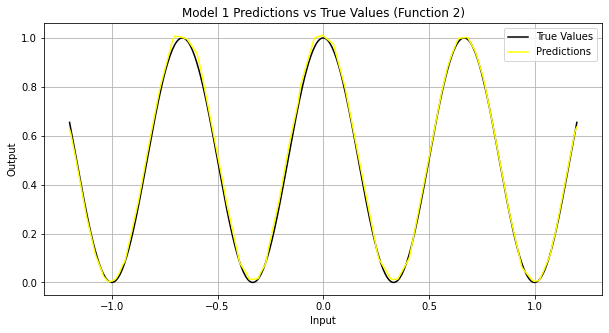

In [98]:
plt.figure(figsize=(10, 5))
plt.plot(m1x2_epoch_arr, m1x2_loss_arr, color="blue")
plt.title('Model 1 Loss (Function 2)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Plot the true vs predicted data for Model 1 (trained on function 2)
plt.figure(figsize=(10, 5))
plt.plot(x2_tensor.numpy(), y2_tensor.numpy(), color="black", label='True Values')
plt.plot(x2_tensor.numpy(), m1y2_prediction.data.numpy(), color="yellow", label='Predictions')
plt.title('Model 1 Predictions vs True Values (Function 2)')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()

In [71]:
# Initialize the model
model_2 = Model_2()

# Define the optimizer (RMSprop) with the model's parameters
optimizer = torch.optim.RMSprop(model_2.parameters(), lr=0.001)

# Train the model using the provided 'train' function
# Use the second function's input (x2_tensor) and target (y2_tensor)
m2x2_epoch_arr, m2x2_loss_arr, m2y2_prediction = train(model_2, x2_tensor, y2_tensor)


Epoch - 0, Loss = 0.1411
Epoch - 300, Loss = 0.0794
Epoch - 600, Loss = 0.0443
Epoch - 900, Loss = 0.0223
Epoch - 1200, Loss = 0.0137
Epoch - 1500, Loss = 0.0099
Epoch - 1800, Loss = 0.0041
Epoch - 2100, Loss = 0.0031
Epoch - 2400, Loss = 0.0027
Epoch - 2700, Loss = 0.0025
Epoch - 3000, Loss = 0.0023
Epoch - 3300, Loss = 0.0023
Epoch - 3600, Loss = 0.0022
Epoch - 3900, Loss = 0.0020
Epoch - 4200, Loss = 0.0020
Epoch - 4500, Loss = 0.0019
Epoch - 4800, Loss = 0.0020
Epoch - 5100, Loss = 0.0019
Epoch - 5400, Loss = 0.0019
Epoch - 5700, Loss = 0.0018
Epoch - 6000, Loss = 0.0017
Epoch - 6300, Loss = 0.0018
Epoch - 6600, Loss = 0.0018
Epoch - 6900, Loss = 0.0016
Epoch - 7200, Loss = 0.0016
Epoch - 7500, Loss = 0.0018
Epoch - 7800, Loss = 0.0016
Epoch - 8100, Loss = 0.0016
Epoch - 8400, Loss = 0.0018
Epoch - 8700, Loss = 0.0018
Epoch - 9000, Loss = 0.0014
Epoch - 9300, Loss = 0.0014
Epoch - 9600, Loss = 0.0016
Epoch - 9900, Loss = 0.0013
Epoch - 10200, Loss = 0.0013
Epoch - 10500, Loss = 0.0

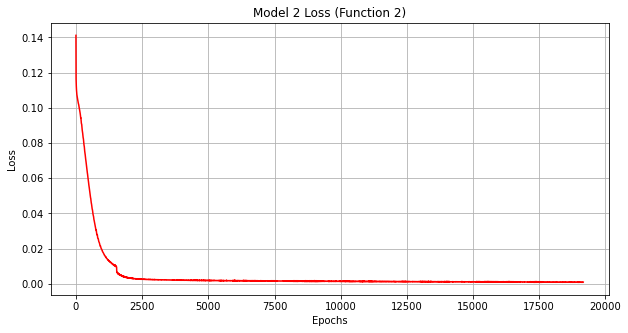

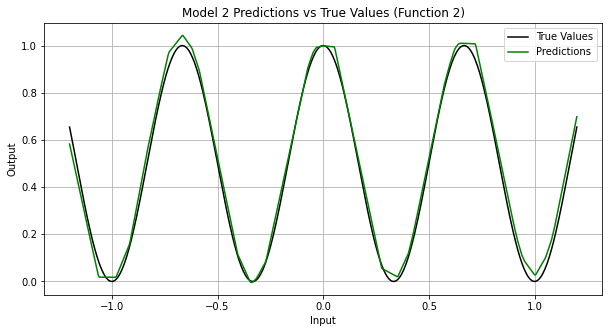

In [99]:
# Plot the loss curve for Model 2 (trained on function 2)
plt.figure(figsize=(10, 5))
plt.plot(m2x2_epoch_arr, m2x2_loss_arr, color="red")
plt.title('Model 2 Loss (Function 2)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Plot the true vs predicted data for Model 2 (trained on function 2)
plt.figure(figsize=(10, 5))
plt.plot(x2_tensor.numpy(), y2_tensor.numpy(), color="black", label='True Values')
plt.plot(x2_tensor.numpy(), m2y2_prediction.data.numpy(), color="green", label='Predictions')
plt.title('Model 2 Predictions vs True Values (Function 2)')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()

In [73]:
# Instantiate the model
model_3 = Model_3()

# Initialize the optimizer (RMSprop) with the model's parameters
optimizer = torch.optim.RMSprop(model_3.parameters(), lr=0.001)

# Train the model using the second set of inputs (x2) and the second function's outputs (y2)
m3_epoch_values, m3_loss_values, m3_y2_predictions = train(model_3, x2_tensor, y2_tensor)

# Display the final results (for verification or visualization)
print(f"Training completed. Epochs: {len(m3_epoch_values)}, Final Loss: {m3_loss_values[-1]:.4f}")


Epoch - 0, Loss = 0.1446
Epoch - 300, Loss = 0.0770
Epoch - 600, Loss = 0.0578
Epoch - 900, Loss = 0.0430
Epoch - 1200, Loss = 0.0323
Epoch - 1500, Loss = 0.0245
Epoch - 1800, Loss = 0.0189
Epoch - 2100, Loss = 0.0147
Epoch - 2400, Loss = 0.0117
Epoch - 2700, Loss = 0.0095
Epoch - 3000, Loss = 0.0079
Epoch - 3300, Loss = 0.0067
Epoch - 3600, Loss = 0.0058
Epoch - 3900, Loss = 0.0052
Epoch - 4200, Loss = 0.0047
Epoch - 4500, Loss = 0.0043
Epoch - 4800, Loss = 0.0040
Epoch - 5100, Loss = 0.0037
Epoch - 5400, Loss = 0.0035
Epoch - 5700, Loss = 0.0033
Epoch - 6000, Loss = 0.0032
Epoch - 6300, Loss = 0.0031
Epoch - 6600, Loss = 0.0030
Epoch - 6900, Loss = 0.0029
Epoch - 7200, Loss = 0.0028
Epoch - 7500, Loss = 0.0027
Epoch - 7800, Loss = 0.0027
Epoch - 8100, Loss = 0.0026
Epoch - 8400, Loss = 0.0025
Epoch - 8700, Loss = 0.0025
Epoch - 9000, Loss = 0.0025
Epoch - 9300, Loss = 0.0024
Epoch - 9600, Loss = 0.0024
Epoch - 9900, Loss = 0.0023
Epoch - 10200, Loss = 0.0023
Epoch - 10500, Loss = 0.0

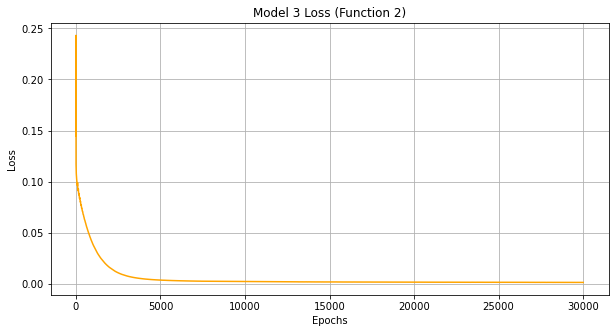

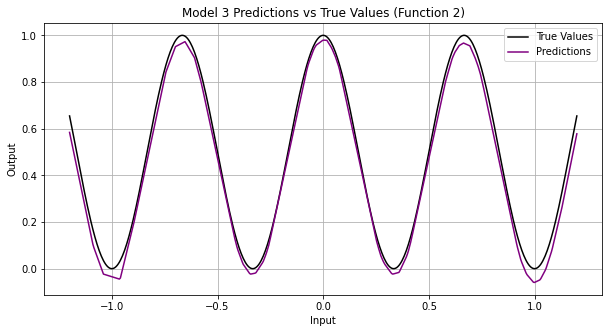

In [100]:
# Plot the loss curve for Model 3 (trained on function 2)
plt.figure(figsize=(10, 5))
plt.plot(m3_epoch_values, m3_loss_values, color="orange")
plt.title('Model 3 Loss (Function 2)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Plot the true vs predicted data for Model 3 (trained on function 2)
plt.figure(figsize=(10, 5))
plt.plot(x2_tensor.numpy(), y2_tensor.numpy(), color="black", label='True Values')
plt.plot(x2_tensor.numpy(), m3_y2_predictions.data.numpy(), color="purple", label='Predictions')
plt.title('Model 3 Predictions vs True Values (Function 2)')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()

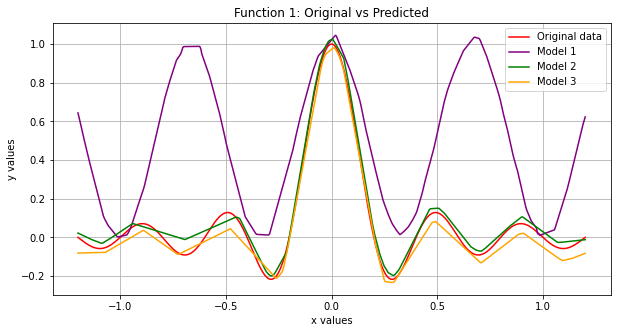

In [74]:
import matplotlib.pyplot as plt

# Ensure x, y, and model predictions (m1y_prediction, m2y_prediction, m3y_prediction) are PyTorch tensors
# Convert them to NumPy arrays for plotting

plt.figure(figsize=(10, 5))
plt.title("Function 1: Original vs Predicted")

# Plot the original data
plt.plot(x.numpy(), y.numpy(), color='red')

# Plot the predictions from the three models
plt.plot(x.numpy(), m1y_prediction.detach().numpy(), color='purple')
plt.plot(x.numpy(), m2y_prediction.detach().numpy(), color='green')
plt.plot(x.numpy(), m3y_prediction.detach().numpy(), color='orange')

# Add a legend to distinguish between the original data and model predictions
plt.legend(['Original data', 'Model 1', 'Model 2', 'Model 3'])

# Label the x and y axes
plt.xlabel("x values")
plt.ylabel("y values")

# Display the plot
plt.grid(True)  # Adding grid for clarity
plt.show()


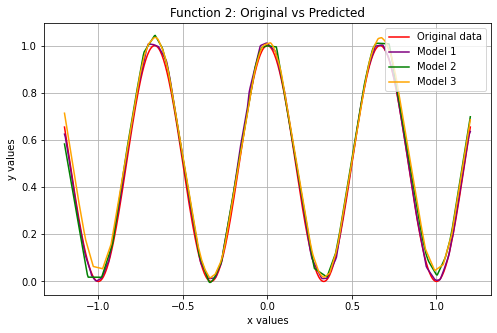

In [75]:
import matplotlib.pyplot as plt

# Plotting function 2: original vs predicted from three different models
plt.figure(figsize=(8, 5))
plt.title("Function 2: Original vs Predicted")

# Plot original data (cosine-based function output)
plt.plot(x2_tensor.numpy(), y2_tensor.numpy(), color='red', label='Original data')

# Plot predictions from three different models
plt.plot(x.numpy(), m1y2_prediction.detach().numpy(), color='purple', label='Model 1')
plt.plot(x.numpy(), m2y2_prediction.detach().numpy(), color='green', label='Model 2')
plt.plot(x.numpy(), m3y2_prediction.detach().numpy(), color='orange', label='Model 3')

# Add legend, labels, and show the plot
plt.legend()
plt.xlabel("x values")
plt.ylabel("y values")
plt.grid(True)
plt.show()


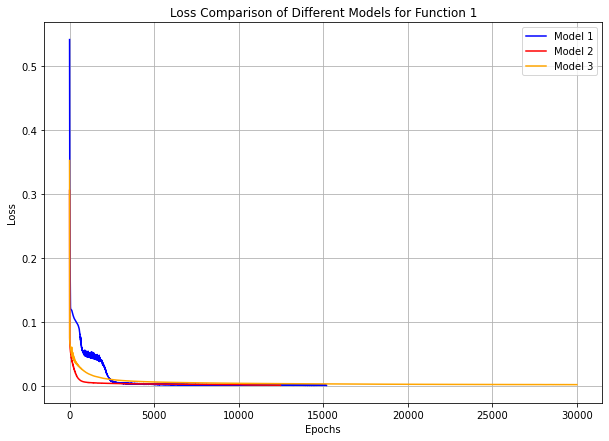

In [76]:
import matplotlib.pyplot as plt

# Creating the figure for loss comparison of different models
plt.figure(figsize=(10, 7))
plt.title("Loss Comparison of Different Models for Function 1")

# Plotting the loss curves for each model
plt.plot(m1x_epoch_arr, m1x_loss_arr, color='blue', label='Model 1')
plt.plot(m2x_epoch_arr, m2x_loss_arr, color='red', label='Model 2')
plt.plot(m3x_epoch_arr, m3x_loss_arr, color='orange', label='Model 3')

# Adding legend, labels, and displaying the plot
plt.legend()  # Automatically picks up the labels from the plot functions
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)  # Adding grid for better visual comparison
plt.show()


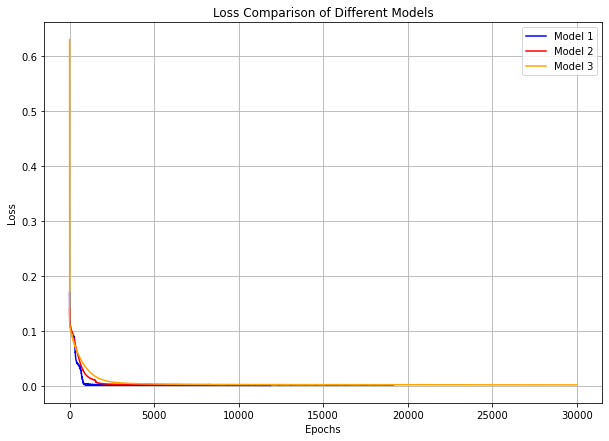

In [77]:
import matplotlib.pyplot as plt

def plot_loss_comparison(models_loss_data, title="Loss Comparison of Different Models", xlabel="Epochs", ylabel="Loss"):
   
    plt.figure(figsize=(10, 7))
    plt.title(title)

    # Plot each model's loss curve
    for epoch_arr, loss_arr, model_label, color in models_loss_data:
        plt.plot(epoch_arr, loss_arr, color=color, label=model_label)

    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

# Example data for three models (replace with actual arrays)
models_loss_data = [
    (m1x2_epoch_arr, m1x2_loss_arr, 'Model 1', 'b'),
    (m2x2_epoch_arr, m2x2_loss_arr, 'Model 2', 'red'),
    (m3x2_epoch_arr, m3x2_loss_arr, 'Model 3', 'orange')
]

# Call the function to plot the loss comparison
plot_loss_comparison(models_loss_data)
